# True Wind

## Summary

We will investigate the computation of TWA/TWD/TWS.  Naive approaches, while they work reasonably well, will not match what is computed on the boat.  

The final proposed approach has a much more complex derivation, but it matches the boat estimates perfectly and is nevertheless fairly simple to implement and fast.


## Glossary

### Instruments and their Measurements
- AWA: apparent wind angle, the angle of the wind blowing at the top the mast (fast but noisy)
- AWS: apparent wind speed, the speed at the mast head (fast and noisy)
- SPD: boat speed **through the water** measured with the paddle wheel speedo in the hull (fast and noisy)
- HDG: compass heading (on PG this is magnetic northa and not true north, though easily corrected using magnetic variation/declination).
- COG and SOG: course and speed over ground from the GPS (these are relative to true north not magnetic on PG). These can differ from HDG/SPD because of current and leeway.

### Computed Quantities
- TWS: true wind speed, the speed of the wind over the ground (computed from the above quantities using the "wind triangle").
- TWD: true wind direction, the angle of the wind blowing over the ground (see "wind triangle").
- TWA: true wind angle, the angle of the wind over the ground reported relative the orientation of the boat (same)

### Other Quantities of Interest
- CURRENT: Speed of water flow triggered by tides.
- DEPTH: depth of water beneath the sensor.
- TIDES: Principally used to understand depth, and predict currents

In [ ]:
# Load some libraries
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import numpy as np
from numba import jit

# These are libraries written for RaceAnalysis
import global_variables
G = global_variables.init_seattle()
import race_logs
import process as p
import analysis as a
import chart as c

In [2]:
import importlib
importlib.reload(race_logs)

<module 'race_logs' from '/Users/viola/GDriveBV/Sailboat/Code/Python/sailing/race_logs.py'>

In [3]:
# Info about all race logs are stored in a DataFrame.
log_info = race_logs.read_log_info()

log_info = race_logs.read_log_info()

examples = [race_logs.get_log(log_info, "2019-12-07"),
            race_logs.get_log(log_info, "2019-11-16")]

In [4]:
dfs, big_df = race_logs.read_logs(examples, path=G.LOGS_DIRECTORY)
df = dfs[1]

Session from 2019-12-07 17:47:04, 124084 rows, 3.4466666666666668 hours.
Session from 2019-11-16 18:09:15.020000, 128865 rows, 3.5797222222222222 hours.


<IPython.core.display.Javascript object>


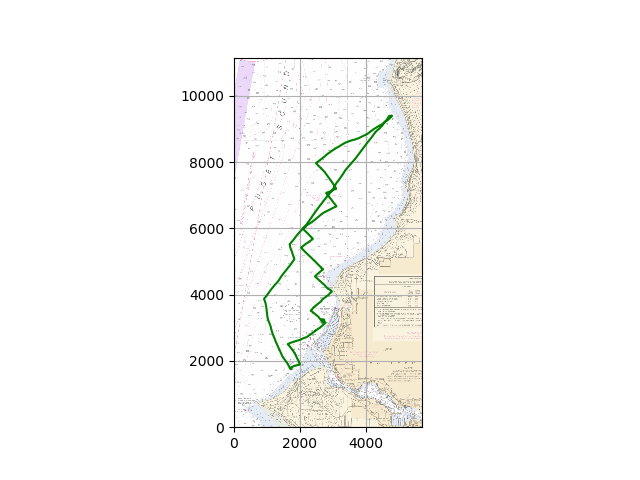

In [5]:
chart = c.plot_chart(df)
c.draw_track(df, chart, color='green')

## Apparent vs. True Wind

Apparent wind conflates the "true wind" and boat movement.  If the boat were stationary (e.g. at the dock) the apparent wind and the true wind are the same (both in speed and direction).  But if the boat is moving it induces apparent "wind" which is equal and opposite to the boat's speed and direction (when you stick your hand out the window of your car on the highway you observe the car's apparent wind).  **True Wind** is an attempt to subtract the boat's boats motion.

Note, AWA, AWS, and SPD are directly measured by sensor units on the boat.  True wind must be computed.

True wind is valuable in part because it is more consistent and drives the strategy that you use on the race course.  Note TWA is reported relative to the boat, and TWD is reported relative to true north. We will see that they are otherwise the same.

We can compute the TWA from AWA/AWS/SPD using the code below.  It is basic vector addition (and trigonometry).

My preferred way to do this is to separate the two components of the apparent wind: i) the wind along the boat (which I think of as "boat north" pointing to the BOW) and ii) the wind perpedicular to the boat, "boat east" or PORT.  The SPD is then subtracted from boat north (since the boat is assumed to be moving forward in the "boat north" coordinates, though there may be [Leeway](https://en.wikipedia.org/wiki/Leeway) or current). All of this can be transformed into global north by adding the boats heading (which we will not do here).  Note, heading (HDG) is reported in magnetic coordinates, not true north, so be careful to add in the magnetic variation.

For more information on sailing instruments the book *Sail Smart: Understand Your Instruments to Sail Faster, Make the Right Calls & Win Races* by Mark Chisnell provides quite a bit of helpful info on boat instruments and measurements. [link](https://www.amazon.com/dp/B07F3CKRLH/ref=cm_sw_em_r_mt_dp_U_Px-gEbZJ52RTX).  The book is short, and for some it will repeat a lot of the basics, but it is helpful none the less.

<IPython.core.display.Javascript object>


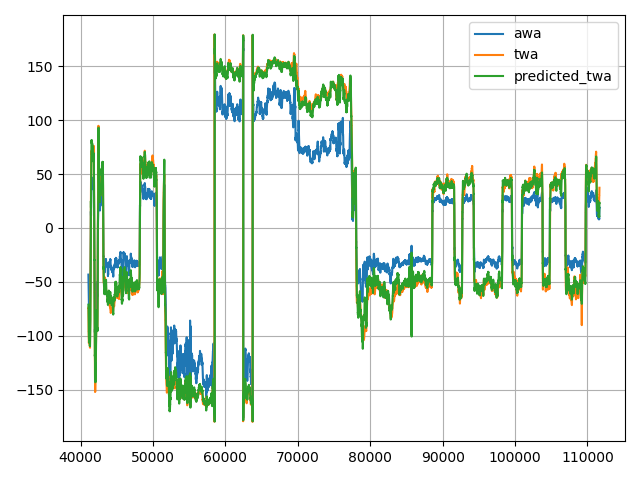

<IPython.core.display.Javascript object>


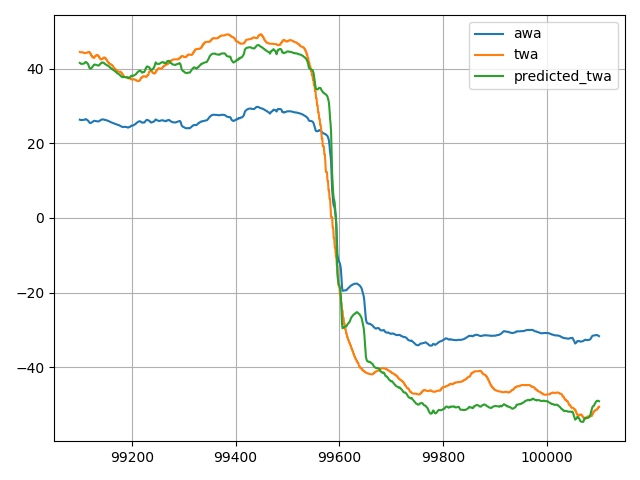

In [6]:
# TWA is computed from AWA, AWS, and boat speed (SPD)
#
# Let's break apparent wind into two components, "boat north" and "boat east".  
# Boat north points to the bow.  Boat east points to starboard.
df['aw_n'] = df.aws * p.cos_d(df.awa)
df['aw_e'] = df.aws * p.sin_d(df.awa)

# For now we will assume the boat moves "boat north" (directly toward the bow)
tw_north = df.aw_n - df.spd # Subtract the boats speed from apparent wind north
tw_east = df.aw_e

# Convert back to an angle
df['predicted_twa'] = np.degrees(np.arctan2(tw_east, tw_north))

wdf = df
c.quick_plot(wdf.index, (wdf.awa, wdf.twa, wdf.predicted_twa), "awa twa predicted_twa".split())

# Let's focus our graphing on a particular slice of the overall log
wide_slice = slice(99100, 99100 + 100 * G.SAMPLES_PER_SECOND)
wdf = df.loc[wide_slice]
c.quick_plot(wdf.index, (wdf.awa, wdf.twa, wdf.predicted_twa), "awa twa predicted_twa".split())

### Close but not perfect.

The basic structure of of the predicted TWA is correct, but many of the fine details are different.  This is particularly apparent when we drill into one tack (above).

Is it possible to get a better fit?  The short answer is yes.

Let's investigate various "artifacts" that may at first seem inconsequential, but will eventually yield to some thought and analysis.

<IPython.core.display.Javascript object>


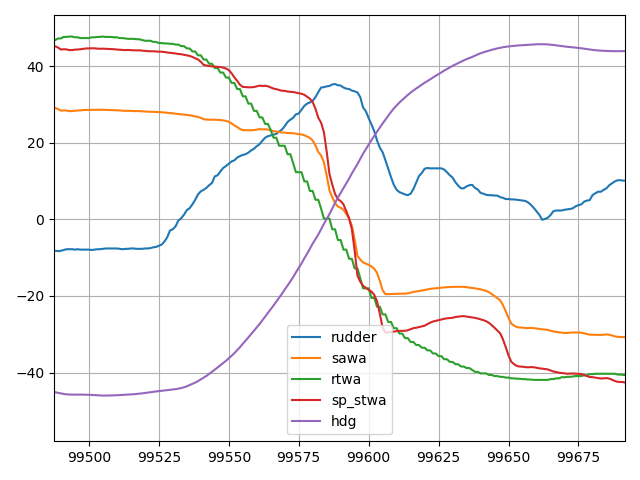

In [7]:
# Let's drill down into one tack and add additional signals to help understand what is going on.
wdf = df.loc[wide_slice]

c.quick_plot(wdf.index, (wdf.rudder, wdf.awa, wdf.twa, wdf.predicted_twa, wdf.hdg-175),   
            "rudder awa rtwa sp_stwa hdg".split())

# Note that TWA seems to be **leading** AWA!
# Note how TWA (from the boat) and HDG have very similar shapes (inverted)!

### TWA seems to lead AWA!!!

We've added RUDDER and HDG to help identify the beginning of the tack (in a sense the tack cannot begin **before** the rudder is turned).  As we expect, after the rudder is turned the HDG responds almost immediately (less than a second).

- RUDDER turn begins at 99525 (though the turn is gradual...  as it should be)
- HDG responds by 99536

First notice, if you zoom in, that TWA (green line) seems to **lead** AWA by as much as 1-2 seconds.  

How could this be if TWA/TWD is computed from AWA??

## Heel and AWA

The figure above is very interesting.


But AWA seems to lag the change in HDG by 2+ seconds (this is true for raw and smoothed AWA).  In a simple model this makes no sense.  Forget, for a moment, that this is a sailboat.  Instead imagine this is a wind sensor on a moving platform.  If you were to rotate the wind sensor toward the wind, then the AWA should decrease (so should the TWA).  

**MY conjecture is that a change in HEEL introduces apparent wind on the mast head.**  As the boat rolls from starboard heel to port heel, the mast head **moves to windward**.  Motion to windward should increase the AWA.

We can investigate this by first smoothing heel (though this time with a non-causal Butterworth for now), and then differentiating (to get roll rate). Finally we can multiply by the mast height to get the velocity at the mast head.

Note, this boat does **not** have a high quality, high frequency HEEL sensor.  Currently the external GPS has both a compass, and a roll/pitch sensor.  Roll is heel,  but it is only reported once a second (which may not be sufficient for this analysis).

In [ ]:
wdf = df.loc[wide_slice]

# Compute a smoothed version of heel.  Note the cutoff is set to 0.3 Hz.  Since the signal is sampled at 1 Hz 
# Nyquist says we cannot hope measure any signal higher than 0.5 Hz.
coeff = p.butterworth_filter(cutoff=0.3, order=5)
# Note causal is false, which will filter the signal but not introduce any delay.
sheel = p.smooth_angle(coeff, wdf.zg100_roll, causal=False)

# Compute the degrees per second rate of change of heel
sample_rate = 10
heel_rate = sample_rate * np.diff(sheel, prepend=sheel[0])

aw_n = wdf.raws * np.cos(np.radians(wdf.rawa))
aw_e = wdf.raws * np.sin(np.radians(wdf.rawa))

c.quick_plot(wdf.index, (wdf.zg100_roll, sheel, heel_rate, 4*aw_n, 4*aw_e), 
            "heel sheel heel_rate 4*aw_north 4*aw_east".split())

## Roll and Wind Dynamics of a Tack

Focus first one AW_NORTH (the wind in the direction of travel).  This goes up as we begin the tack.  This makes sense, since the boat is heavy and will carry its speed as it turns up into the wind.  Briefly,  AW_NORTH is the sum of TWS and SPD (before the tack we were moving across the true wind).

Second look at AW_EAST.  We can see that it drops fast,  but not as fast as AW_NORTH increases.  At some point the wind switches sides, from positive to negative.   But then it does not continue.  Briefly it heads back toward positive.  This, I believe is because the mast begins to rotate to leeward, reducing wind speed.

Third look at the double peak in the roll rate centered around the tack.  While this does not happen in every case it is not uncommon.  In a slow tack, as the boat passes head to wind there is a period where the heel is constant.

## Correcting Apparent Wind with Mast Velocity

Finally,  we can correct the apparent wind velocity, by computing the velocity of the mast head.  The rate of heel change times mast height is the velocity of mast head in the "boat east" direction.

In [ ]:
wdf = df.loc[wide_slice]

# Convert to masthead velocity
feet_per_meters = 0.3048
mast_height = 50 * feet_per_meters
mast_vel = mast_height * np.radians(heel_rate)

# Corrected 
correction = mast_height * np.radians(heel_rate)
caw_e = aw_e - correction

c.quick_plot(wdf.index, (4*aw_n, 4*aw_e, 4*caw_e, 0.4*(wdf.hdg-170)), 
            "awn awe corrected hdg".split())

cawa = np.degrees(np.arctan2(caw_e, aw_n))
caws = np.sqrt(np.square(aw_n) + np.square(caw_e))

scawa, _ = p.exponential_filter_angle(np.array(cawa), alpha, theta)
c.quick_plot(wdf.index, (scawa, wdf.sawa),
                        "smoothed_corrected_AWA smoothed_AWA".split())


The corrected AWA now **leads** smoothed AWA by over a second, and there is no weird bump at the end.

In [ ]:
# Repeat for the entire signal

# Note causal is false, which will filter the signal but not introduce any delay.
sheel = p.smooth_angle(coeff, df.zg100_roll, causal=False)

# Compute the degrees per second rate of change of heel
sample_rate = 10
heel_rate = sample_rate * np.diff(sheel, prepend=sheel[0])

# Convert to masthead velocity
mast_vel = mast_height * np.radians(heel_rate)

# Break apparent wind into the component aligned with the boat "north" and the component aligned with roll, "east".
aw_n = df.raws * np.cos(np.radians(df.rawa))
aw_e = df.raws * np.sin(np.radians(df.rawa))

# Corrected 
caw_e = aw_e - mast_vel

df['cawa'] = np.degrees(np.arctan2(caw_e, aw_n))
df['caws'] = np.sqrt(np.square(aw_n) + np.square(caw_e))

df['scawa'], _ = p.exponential_filter_angle(np.array(df.cawa), alpha, theta)
df['scaws'], _ = p.exponential_filter(np.array(df.caws), 0.93, 0.5)

tw_north = p.cos_d(df.cawa) * df.caws - df.rspd
tw_east = p.sin_d(df.cawa) * df.caws

df['predicted_twa'] = np.degrees(np.arctan2(tw_east, tw_north))
# increase smoothness... seems to be a better fit
alpha = 0.97
df['spredicted_twa'], _  = p.exponential_filter_angle(np.array(df.predicted_twa), alpha, theta)

wdf = df.loc[tacks_slice]
c.quick_plot(wdf.index, (wdf.rawa, wdf.predicted_twa, wdf.rtwa), "rawa predicted_twa rtwa".split())

c.quick_plot(wdf.index, (wdf.cawa, wdf.scawa, wdf.rawa, wdf.sawa),
                        "cawa scawa rawa sawa".split())


In [ ]:
wdf = df.loc[wide_slice]

c.quick_plot(wdf.index, (wdf.rudder, wdf.scawa, wdf.rtwa, wdf.spredicted_twa, wdf.hdg-175),   
            "rudder scawa rtwa sp_twa hdg".split())

## Summary 

1. We have defined a non-linear exponential filter that appears to remove noise without introducing too much delay.

Conventional causal linear filtering introduced too much delay.

2. We created a scheme for correcting AWA using heel (aka roll).  

We observed a delay in the **raw AWA** from what we expected to see (it should track HDG closely). Correcting with the derivative of the heel reduces this delay significantly.

(For the time being let's ignore these observations and return to the estimate of TWA/TWD/TWS.  In particular I do not beleive the B&G instruments on my boat are using HEEL to correct AWA, so we will return to this later.)


## Back to TWA/TWS

While we can clearly see that the fit is much better than before there are still some issues.

1. The fit to TWA is good on the coarse level, but does not fit in the details.
1. Boat TWA is both smoother and it **leads** our predicted TWA.

(Both of these issues are subtle.)

Another observation is worth making. **Notice that TWA and HDG are mirror images**.  Though it might be hard to see in this graph.  We can investigate this be trying to predict TWA from HDG alone.  

In [ ]:
def least_square_fit(target, signal):
    "Compute the least squares fit of target from signal."
    a = np.vstack((signal, np.ones((len(signal))))).T
    b = np.asarray(target)
    fit = np.linalg.lstsq(a, b, rcond=None)[0]
    predictions = a.dot(fit)
    return fit, predictions

In [ ]:
# Let's try to predict the TWA from HDG alone ?!?!!?
wdf = df.loc[wide_slice]
# For a short time slice is TWA a linear function of HDG?
fit, pred = least_square_fit(wdf.rtwa, wdf.rhdg)
c.quick_plot(wdf.index, (wdf.rtwa, pred, wdf.rawa, wdf.rudder), "rtwa predicted_from_hdg awa rudder".split())

In [ ]:
print(f"Best fit for TWA is {fit[1]:.3f} {fit[0]:+.3f} * HDG")
abs_error = np.abs(wdf.rtwa - pred)
print(f"Average error is {np.mean(abs_error):.3f} degrees")


To repeat, **we can predict TWA from HDG alone**!!  With an average error of about 1.8 degrees.

Both the fit and the graph show that the HDG and TWA are closely related (the blue and orange curves above).

Why is it possible to predict TWA from HDG alone?  It actually makes sense from a physical standpoint: if **TWA = (TWD - HDG)** and **TWD** is roughly constant over a period of time (1000/10 = 100 seconds). During this period TWD must have been approximately 179 degrees.  

To review, the rudder is turned at $t = 99500$ and the HDG (and TWA) respond very soon after (less than a second).  The AWA is still above 20 until 99572 (5 seconds!), but at this point TWA has dropped from 45 down to 14 degrees!!

What is going on here?  Why does the change in TWA come ahead of the change in AWA?  Why does it seem to track HDG almost perfectly?

Perhaps the above framework for computing TWA/TWS and filtering are too simplistic.

Rather than estimate TWA/TWS, perhaps it is better to estimate TWD/TWS (true wind direction and speed).  This is a quantity of the **world**, and while it varies with time, these processes do not depend on the boat.  So for example, some boats tack a lot and others very rarely.  Some boat have great drivers that keep a consistant TWA and others vary a lot.  Estimating TWA requires a filtering process that can be robust to these differences.  TWD depends only on the physics of wind in the world.

TWA is then computed from TWD by subtracting HDG. And this explains why TWA can lead AWA. If we can estimate TWD, the TWA will react immeadiately as HDG changes. 

In [ ]:
# Too many open graphs... 
# plt.close('all')

In [ ]:
# Let's verify that TWD and TWA are directly related by HDG + variation
variation = df.variation.mean()
twd_from_twa = np.mod(df.rtwa + df.hdg + variation, 360)

abs_diff = np.abs(df.rtwd - twd_from_twa)

print(f"The average absolute difference between TWD and TWA+HDG is {abs_diff.mean()}")
print(f"The 99th percentile of the abs difference is {np.percentile(abs_diff, 99)}")
print(f"The max abs difference is {np.percentile(abs_diff, 100)}")

m = df.rtwd.mean()
c.quick_plot(df.index, (df.rtwd-m, twd_from_twa-m, df.rtwa),
               "twd twd_twa twa".split())


### How to estimate TWD/TWS directly?

I started out considering a Kalman filter.  The classic Kalman filter would proceed by iterating two steps: propagate and update.

A Kalman filter works in reverse from our approach above: given the current estimate of TWD/TWS (and HDG and SPD) it predicts AWA, AWS (rather than computing TWD/TWS from AWA/AWS).  If these predictions are in error a Kalman filter updates TWD/TWS to reduce these errors.  This is the "update step".

Propagate takes the current estimate and computes a new estimate.  This is the place to incorporate our sense of how fast wind direction may change.

A fully probabilistic derivation of the Kalman filter also involves covariance matrices.

A simpler, though similar alternative, is an iterative filter, which starts with a guess at TWD/TWS (perhaps random).  For each new observation perform the following stesp.

1. Observe AWA, AWS, HDG, and SPD
1. Predict AWA and AWS from HDG, SPD and the current guess for TWD and TWS
1. Measure the error in this prediction.
1. Update TWD/TWS to reduce this error. 

By keeping the changes in the final step small the filter produces a smooth version of TWD/TWS.   

### Update equations

The goal is to determine how to update estimates for TWA and TWS given observations.  We will do this by taking the derivative of the observation equations.  These derivatives are used to update the estimates to reduce the residuals.

Short hand:

    twa = twd - (hdg + var)
    c   = cos(twa)
    s   = sin(twa)

These are the predicted observations, given the hidden state: TWD/TWS.

    predicted_aw_n = spd + c * tws
    predicted_aw_e =       s * tws

And these are the residuals (the difference between actual and predicted).

    r_n = (aw_n - predicted_aw_n)
    r_e = (aw_e - predicted_aw_e)
    
And below are the derivates of aw_n and aw_e with respect to tws and twd (in that order).
    
    d_aw_n = [    c,   tws * -s]
    d_aw_e = [    s,   tws *  c]
    
Given residuals, we can update the parameters using the derivatives of the predictions

    delta_tws = r_n * c         + r_e * s
    delta_twa = r_n * tws * -s  + r_e * tws * c

Sure...  that is the math,  but what is the intuition?  Take one half of one term:

    delta_tws = r_n * c
              = (aw_n - predicted_aw_n) * cos(twa)
    
It says that if aw_n is greater than the predicted, then increase tws if twa is less than 90, and decrease if it greater than 90.

    delta_twa = r_n * tws * -s
              = (aw_n - predicted_aw_n) * tws * -1 * sin(twa)
              
This says that if aw_n is greater than predicted, then decrease twa.

**Note**, these are directions of update tws and twd over time.  The rate of change is proportional to an adaptation rate $\epsilon$.  Small values for $\epsilon$ will lead to small and gradual changes in twd/tws: smoother estimates but larger residuals.  Small values introduce smoothing/damping/filtering. 


In [ ]:
@jit(nopython=True)
def estimate_true_wind_helper(epsilon, aws, awa, hdg, spd, tws, twd, variation, tws_mult):
    twd = np.radians(twd) + np.zeros(awa.shape)
    tws = tws + np.zeros(awa.shape)
    res_n = np.zeros(awa.shape)
    res_e = np.zeros(awa.shape)
    aw_n = aws * np.cos(np.radians(awa))
    aw_e = aws * np.sin(np.radians(awa))

    rhdg = np.radians(hdg)
    variation = np.radians(variation)

    for i in range(1, len(aws)):
        twa = twd[i-1] - (rhdg[i] + variation)
        c = np.cos(twa)
        s = np.sin(twa)
        # The forward predictions
        f_aw_n = spd[i] + c * tws[i-1]
        f_aw_e =          s * tws[i-1]

        # Residuals
        res_n[i] = (aw_n[i] - f_aw_n)
        res_e[i] = (aw_e[i] - f_aw_e)

        # derivatives
        delta_tws = res_n[i] * c + res_e[i] * s
        delta_twd = res_n[i] * tws[i-1] * -s + res_e[i] * tws[i-1] * c

        # Hack, which the update to TWS and TWD don't have the same magnitude
        tws[i] = epsilon * tws_mult * delta_tws + tws[i-1]
        twd[i] = epsilon * delta_twd + twd[i-1]

    return np.degrees(twd), tws, res_n, res_e

def estimate_true_wind(epsilon, df, awa_mult=1.0, aws_mult=1.0, spd_mult=1.0, awa_offset=0, tws_mult=30):
    return estimate_true_wind_helper(epsilon,
                                     aws = aws_mult * np.asarray(df.raws),
                                     awa = awa_mult * np.asarray(df.rawa) + awa_offset,
                                     hdg = np.asarray(df.rhdg),
                                     spd = spd_mult * np.asarray(df.rspd),
                                     tws = df.tws.iloc[0],
                                     twd = df.twd.iloc[0],
                                     variation = df.variation.mean(),
                                     tws_mult = tws_mult
                                    )

In [ ]:
# Sorry about these magic numbers...  more below
param = DictClass(df=df, awa_mult=1.0,  aws_mult=1.0,  spd_mult=1.1, 
                  awa_offset=0, tws_mult=16, epsilon=0.0003)

if True:
    (twd, tws, res_n, res_e) = estimate_true_wind(**param)
    df['ptwd'] = twd
    df['ptwa'] = twd - (df.rhdg + variation)
    df['ptws'] = tws

wdf = df.loc[tacks_slice]    
wdf = df
print((wdf.rtwa - wdf.ptwa).abs().mean())
print((wdf.rtwd - wdf.ptwd).abs().mean())
print((wdf.rtws - wdf.ptws).abs().mean())

c.quick_plot(wdf.index, (wdf.rtwa, wdf.ptwa), "rtwa predicted_twa".split())
    
wdf = df
c.quick_plot(wdf.index, (wdf.rtwd-180, wdf.ptwd-180, 10*wdf.rtws, 10*wdf.ptws),
                 "twd ptwd tws ptws awa".split())

## Near Perfect Match

*I was astonished at the quality of this fit.**

1. The shape and details are almost everywhere identical, down to the finest details.
1. The areas where the match is not perfect corresponds to areas with very low TWS (2 knots).  This is to be expected, because wind direction is hard to measure when the wind speed is low.

From this I conclude that we almost certainly have the correct algorithm.  And that includes the flaws that we will investigate below.  (... why would we want an algorithm with flaws?  Becuase only be understanding the algorithm can we fix the flaws ...)

### Optimization to find the best parameters

Note, the magic numbers above can be automatically estimated from optimization code below.

The approach is simple, search for a set of 

In [ ]:
from scipy.optimize import minimize

# Returns a score base on the fit between our predicted TWS/TWD and the logged quantities.
def fit(m):
    (twd, tws, res_n, res_e) = estimate_true_wind(m[5], df, m[0], m[1], m[2], m[3], m[4])    
    df['ptwd'] = twd
    df['ptwa'] = twd - (df.rhdg + variation)
    df['ptws'] = tws

    wdf = df
    ctwa = 0.2 * (wdf.rtwa - wdf.ptwa).abs().mean()
    ctwd = 1 * (wdf.rtwd - wdf.ptwd).abs().mean()
    ctws = 1 * (wdf.rtws - wdf.ptws).abs().mean()
    return ctwa + ctwd + ctws

# Initial conditions
m0 = np.array([1.0, 1.0, 1.0, 0.0, 30, 0.0001])

# Note this can take up to a minute.
res = minimize(fit, m0, method='nelder-mead',
               options={'xatol': 1e-5, 'disp': True})

print(res.x)

## Summary

We have proposed a single stage, error driven, filtering algorithm for estimating TWD/TWS directly, and from this computing TWA.  

This is unlike the initial approach investigated computed TWA/TWS directly from AWA/AWS/SPD and then filtered to smooth out noise.

In this new approach, there is a single estimation process, where smoothness depends on epsilon.  And it near perfectly fits the quantities estimated on the boat!

While this explains the mystery of TW on the boat, **the estimates are almost certainly wrong**!

Below let's drill down to some tacks.

In [ ]:
wdf = df.loc[tacks_slice]    

c.quick_plot(wdf.index, (wdf.sawa, wdf.rtwa, wdf.rtwd-180, wdf.rhdg-180),
                 "sawa twa twd hdg".split())

## Tacks seem to have a radical impact on TWD

Notice how changes in TWD seems to be tightly coupled to the tacks.  Every tack leads to a immediate change in TWD, which eventually converges to as much as 15 degrees (in 30-50 seconds). Note, I briefly considered the possibility that the tacks were in response to these changes.  But the reality is that the TWD changes **after** the tack and never before.

**These tack related changes are almost certainly artifacts.**  

A simple approach to remove these "hitches" is to smooth out TWD (by decreasing epsilon). 
- These shifts take 50-100 seconds to take effect.  Smoothness would need to be radical.
- This might be acceptable if the TWD is not varying much,  but it would miss (smooth out) changes that are likely important.  I

In [ ]:
# Reduce epsilon
reduce = 0.1
m = DictClass(df=df, awa_mult=1.0,  aws_mult=1.0,  spd_mult=1.1, 
              awa_offset=0, tws_mult=reduce*16.109, epsilon=reduce*0.0003)

(twd, tws, res_n, res_e) = estimate_true_wind(**m)
    
df['ptwd'] = twd
df['ptwa'] = twd - (df.rhdg + variation)
df['ptws'] = tws

wdf = df.loc[tacks_slice]    

c.quick_plot(wdf.index, (wdf.sawa, wdf.ptwa, wdf.rtwd-180, wdf.ptwd-180),
                 "sawa twa twd hdg".split())

## Smoother, but still wrong.

**While TWD is much smoother, there are still issues:*

1. There is a significant hitch associated with each tack.
2. This smoothing will eliminate true rapid changes in TWD.

## Using Heel Corrected AWA/AWS

**Perhaps this artifact can be corrected by using the improved estimates of AWA (using HEEL)?**

In [ ]:
reduce = 0.1
m = DictClass(df=df, awa_mult=1.0,  aws_mult=1.0,  spd_mult=1.1, 
              awa_offset=0, tws_mult=reduce*16.109, epsilon=reduce*0.003)

# Note, we are using CAWS and CAWA below
(twd, tws, res_n, res_e) = estimate_true_wind_helper(
    m.epsilon,
    aws = m.aws_mult * np.asarray(df.caws),
    awa = m.awa_mult * np.asarray(df.cawa) + m.awa_offset,
    hdg = np.asarray(df.rhdg),
    spd = m.spd_mult * np.asarray(df.rspd),
    tws = df.tws.iloc[0],
    twd = df.twd.iloc[0],
    variation = df.variation.mean(),
    tws_mult = m.tws_mult
)

df['ptwd'] = twd
df['ptwa'] = twd - (df.rhdg + variation)
df['ptws'] = tws

wdf = df.loc[tacks_slice]    

c.quick_plot(wdf.index, (wdf.sawa, wdf.ptwa, wdf.rtwd-180, wdf.ptwd-180),
                 "sawa ptwa rtwd ptwd".split())

Correcting AWA/AWS for heel does not seem to help much.  That makes sense, because the heel induced error in AWA only arises **during** a tack, for at most 10 seconds.


## Is the problem Leeway?

Leeway is the tendency of a boat to slip to leeward as it sails upwind. Naively, one might imagine that the boat sails in the direction it is pointed.  In practice the boat is likely slipping 2-10 degrees lower than the HDG, and this is called leeway.

As the apparent wind passes over the sail, the lift/force generated can be decomposed into two components: one in the direction of boat travel (drive), and a second perpendicular to travel (heel).  The drive force keeps the boat moving; the heel pushes sideways and causes heel (no surprise) and also a drift to leeward.  Upwind sailing is possible because as the boat begins to move the keel generates lift as well.  Since the keel is a symmetric wing, it must have a positive angle of attack to generate lift (to counteract the heeling force).  In this way, the COG is lower than HDG, and the angle is the Leeway.

So there are really two intuitions:
- Since the sail lift has a component to leeward there must be some drift to leeward.
- Since the keel must counteract the leeward force, it must point slightly higher than the COG.

### How does leeway effect TWA/TWD?

Intuitively,  if the boat is slipping to leeward (which is away from the wind) then the measured AWA would be decreased.  So for a given AWA the estimated TWS should be a bit larger with leeway.  

### COG/SOG are delayed

A quick aside.  As we learned in the notebook on [Instrument_Delays.ipynb](Instrument_Delays.ipynb), COG/SOG are delays WRT to other signals on the boat.  We can address this delay by "looking ahead" to used later measurements when computing.  Since we have all the data together from the log, this is easy (just use later entries in the log).  This can be done online as well (while sailing) by delaying the TWD/TWS calculation.


In [ ]:
wdf = df
c.quick_plot(wdf.index, (wdf.rspd, wdf.rsog), "spd sog".split())
c.quick_plot(wdf.index, (wdf.rcog, wdf.rhdg), "cog hdg".split())

In [ ]:
@jit(nopython=True)
def estimate_true_wind_helper_leeway2(epsilon, aws, awa, hdg, spd, cog, sog, 
                                     tws_init, twd_init, variation, tws_mult, shift):
    # TWD/TWS are ouptputs.  This sets the initial conditions.
    twd = np.radians(twd_init) + np.zeros(awa.shape)
    tws = tws_init + np.zeros(awa.shape)
    # Residuals are stored here.
    res_n = np.zeros(awa.shape)
    res_e = np.zeros(awa.shape)
    # Process apparent wind to decompose into boat relative components.
    aw_n = aws * np.cos(np.radians(awa))
    aw_e = aws * np.sin(np.radians(awa))

    # preconvert some values
    rhdg = np.radians(hdg)
    rcog = np.radians(cog)
    variation = np.radians(variation)
    
    eps = epsilon
    for i in range(1, len(aws)-shift):
        # Transform to boat relative angles.
        twa = twd[i-1] - (rhdg[i] + variation)
        course_angle = rcog[i+shift]  - (rhdg[i] + variation)
        
        # Useful below
        c = np.cos(twa)
        s = np.sin(twa)
        
        # Boat relative vector of true wind
        twn = c * tws[i-1]
        twe = s * tws[i-1]
        
        # Boat relative vector of travel
        btn = np.cos(course_angle) * sog[i+shift]
        bte = -np.sin(course_angle) * sog[i+shift]
        
        # The forward predictions, introduce leeway
        f_aw_n = twn + btn
        f_aw_e = twe + bte

        # Residuals
        res_n[i] = (aw_n[i] - f_aw_n)
        res_e[i] = (aw_e[i] - f_aw_e)

        # derivatives
        delta_tws = res_n[i] * c + res_e[i] * s
        delta_twd = res_n[i] * tws[i-1] * -s + res_e[i] * tws[i-1] * c

        if np.sqrt(np.square(res_n[i]) + np.square(res_e[i])) > 1.5:
            eps = min(5*epsilon, 1.1 * eps)
        else:
            eps -= 0.2 * (eps - epsilon)
        
        # Hack, which the update to TWS and TWD don't have the same magnitude
        tws[i] = eps * tws_mult * delta_tws + tws[i-1]
        twd[i] = eps * delta_twd + twd[i-1]

    return np.degrees(twd), tws, res_n, res_e



In [ ]:
reduce = 0.3
m = DictClass(df=df, awa_mult=1.0,  aws_mult=1.0,  spd_mult=1.1, 
              awa_offset=0, tws_mult=reduce*100, epsilon=reduce*0.0003)

wdf = df
c.quick_plot(wdf.index, (wdf.scawa, wdf.rtwd-180))

rrr = [12]
for i in rrr:
    # Note, we are using CAWS and CAWA below
    (twd, tws, res_n, res_e) = estimate_true_wind_helper_leeway2(
    m.epsilon,
    aws = m.aws_mult * np.asarray(df.caws),
    awa = m.awa_mult * np.asarray(df.cawa) + m.awa_offset,
    hdg = np.asarray(df.rhdg),
    spd = m.spd_mult * np.asarray(df.rspd),
    cog = np.asarray(df.rcog),
    sog = np.asarray(df.rsog),
    tws_init = df.tws.iloc[0],
    twd_init = df.twd.iloc[0],
    variation = df.variation.mean(),
    tws_mult = m.tws_mult,
    shift = i
    )
    plt.plot(wdf.index, twd-180)

plt.legend("scawa rtwd".split() + ["delay_"+str(i) for i in rrr])



In [ ]:
reduce = 0.3
m = DictClass(df=df, awa_mult=1.0,  aws_mult=1.0,  spd_mult=1.1, 
              awa_offset=0, tws_mult=reduce*100, epsilon=reduce*0.0003)

wdf = df
c.quick_plot(wdf.index, (wdf.scawa, wdf.rtwd-180))

rrr = [0, 12, 20]
for i in rrr:
    # Note, we are using CAWS and CAWA below
    (twd, tws, res_n, res_e) = estimate_true_wind_helper_leeway2(
    m.epsilon,
    aws = m.aws_mult * np.asarray(df.caws),
    awa = m.awa_mult * np.asarray(df.cawa) + m.awa_offset,
    hdg = np.asarray(df.rhdg),
    spd = m.spd_mult * np.asarray(df.rspd),
    cog = np.asarray(df.rcog),
    sog = np.asarray(df.rsog),
    tws_init = df.tws.iloc[0],
    twd_init = df.twd.iloc[0],
    variation = df.variation.mean(),
    tws_mult = m.tws_mult,
    shift = i
    )
    plt.plot(wdf.index, twd-180)

plt.legend("scawa rtwd".split() + ["delay_"+str(i) for i in rrr])



In [ ]:
plt.figure()
plt.plot(res_e)
plt.plot(res_n)
residuals = np.sqrt(np.square(res_n) + np.square(res_e))
plt.plot(residuals)

plt.figure()
plt.hist(residuals, bins=30)